In [1]:
import torch
import numpy as np
import torch.utils
import requests
from transformers import BertTokenizer, BertModel
from  data import create_dataset
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
torch.manual_seed(42)
np.random.seed(42)
MAX_LEN = 13

In [2]:
def encode(tokenizer, sentences):
    input_ids = []
    attention_masks = []
    for sentence in sentences:

        encoded_dict = tokenizer.encode_plus(
                            sentence,                  
                            add_special_tokens=True,   # Add '[CLS]' and '[SEP]'
                            max_length=MAX_LEN+1,             # Adjust sentence length
                            padding='max_length',    # Pad/truncate sentences
                            return_attention_mask=True,# Generate attention masks
                            return_tensors='pt',       # Return PyTorch tensors
                            truncation = False
                    )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        # Construct an attention mask (identifying padding/non-padding).
    input_ids = torch.cat(input_ids,dim=0)
    attention_masks = torch.cat(attention_masks,dim=0)
    
    return   input_ids,attention_masks 

def max_length(sentence):
    max_len= 0 
    for sen in sentence:
        a,b,c,d = sen.split()
        la = len(a)
        lb = len(b)
        lc = len(c)
        ld = len(d)
        size = max(la,lb,lc,ld)
        if size> max_len:
            max_len = size
    return max_len
    
def token(data, tokenizer):
    input_a = []
    input_b = []
    input_c = []
    input_d = []
    MAX_LEN = max_length(data)
    for sentence in data:
    
        a,b,c,d = sentence.split()
        input_a.append(a)
        input_b.append(b)
        input_c.append(c)
        input_d.append(d)
    input_idA, maskA = encode(tokenizer, input_a)
    input_idB, maskB = encode(tokenizer, input_b)
    input_idC, maskC = encode(tokenizer, input_c)
    input_idD, maskD = encode(tokenizer, input_d)
    
    return input_idA, maskA, input_idB, maskB, input_idC, maskC, input_idD, maskD

def embedding(model,tokens_tensor, attention_masks):
    with torch.no_grad():
        outputs = model(tokens_tensor, attention_mask=attention_masks)
    hidden_states = outputs.last_hidden_state
    #CLS contains all the information of the sentence so we use CLS token for embedding
    CLS_embedding = hidden_states[:,0,:]
    
    return CLS_embedding


def l2_dist(ab,c,d_prime, k = 20):
    candidates = []
    for d in d_prime:
        temp = c-d
        cos = torch.dot(temp,ab)/(torch.norm(temp,p=2)*torch.norm(ab,p=2))
        candidates.append(cos)
    return  torch.topk(torch.Tensor(candidates), k, sorted=True, largest=False)

def cos_sim(ab, c, d_prime, k=20):
    candidates = []
    for d in d_prime:
        temp = c-d
        cos = torch.dot(temp,ab)/(torch.norm(temp,p=2)*torch.norm(ab,p=2))
        candidates.append(cos)
    return  torch.topk(torch.Tensor(candidates), k, sorted=True)
def accuracy(pred, words,k):
    num = 0
    for row in pred:
        if any(x == words[i] for i,x in enumerate(row[:k])):
            num+=1
    return num/len(words)

def vissualize(sentence_features, group):
    pca = PCA(n_components=2)
    pca.fit(sentence_features)
    print(np.sum(pca.explained_variance_ratio_))
    pca_sentence_features = pca.transform(sentence_features)
    plt.figure(figsize=(10,10))
    for i in range(len(pca_sentence_features)):
        plt.scatter(pca_sentence_features[i,0],pca_sentence_features[i,1])
        plt.annotate(f'{group} ',(pca_sentence_features[i,0],pca_sentence_features[i,1]))
    plt.show()

def prediction(data,model,tokenizer, k_groups,groups):
    #Tokenize a,b,c,d and their coresponding masks
    input_idA, maskA, input_idB, maskB, input_idC, maskC, input_idD, maskD = token(data,tokenizer)
    #Add B and D together
    
    cd = torch.concat((input_idB,input_idD),0)
    #maskUnique = torch.concat((maskB,maskD), 0)

    #Find unique words from tokens B and D
    unique_words = {tuple(tensor) for tensor in cd.tolist()}
    unique_lst = [list(lst) for lst in unique_words]
    unique_tensors = torch.stack([torch.tensor(list(lst)) for lst in unique_words])
    unique_embedding = embedding(model,unique_tensors, maskD[:len(unique_lst)])
    d = torch.Tensor(input_idD).tolist()
    words = [ unique_lst.index(d[i]) for i in range(len(d))]
    #sentence_embedding = embeddings(model, input_ids[:100], torch.tensor(attention_masks[:100]))
    #find the embedding of a,b,c
    embedding_A =  embedding(model, input_idA, maskA)
    embedding_B =  embedding(model, input_idB, maskB)
    embedding_C =  embedding(model, input_idC, maskC)
    input_id , attention_masks = encode(tokenizer,data)
    embedding_sentence = embedding(model,input_id,attention_masks)
    # For each sentence find the top k most likely words
    pred_cos = []
    pred_l2 = []
    for i in range(embedding_A.shape[0]):
        AB = embedding_A-embedding_B
        _, top_k_indicesC = cos_sim(AB[i], embedding_C[i],unique_embedding )
        _, top_k_indicesL = l2_dist(AB[i], embedding_C[i],unique_embedding )
        
        pred_cos.append(top_k_indicesC)
        pred_l2.append(top_k_indicesL)
    
    for k in k_groups:
        print(f'\nk = {k}')
        print(f'Cos Simmiliairty Accuracy : {100*accuracy(pred_cos,words,k):.4f} ')
        print(f'L2 Accuracy :  {100*accuracy(pred_l2,words,k):.4f}')
    vissualize(embedding_sentence,groups)

In [5]:
url = 'https://www.cs.fsu.edu/~liux/courses/deepRL/assignments/word-test.v1.txt'
url_voca = 'https://www.cs.fsu.edu/~liux/courses/deepRL/assignments/bert_vocab.txt'
batch_size = 16
num_epochs = 3
learning_rate = 5e-5

In [6]:
# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', url_vocab= url_voca)
model = BertModel.from_pretrained('bert-base-uncased' , output_hidden_states = True)

In [7]:
#Load Dataset
dataset = create_dataset(url)
data = dataset['capital-common-countries']

In [139]:
max_len = 0
i = 0
index = -1
for sen in data:
    a,b,c,d = sen.split()
    la = len(a)
    lb = len(b)
    lc = len(c)
    ld = len(d)
    size = max(la,lb,lc,ld)
    if size> max_len:
        index = i
        max_len = size
    i+=1
print(data[index])
print(max_len)

Chicago Illinois Boston Massachusetts
13


In [164]:
data = dataset['capital-common-countries']
prediction(data,model,tokenizer, k_group)


k = 1
Cos Simmiliairty Accuracy : 4.3478 
L2 Accuracy :  12.0553

k = 2
Cos Simmiliairty Accuracy : 12.6482 
L2 Accuracy :  12.0553

k = 5
Cos Simmiliairty Accuracy : 17.7866 
L2 Accuracy :  25.6917

k = 10
Cos Simmiliairty Accuracy : 37.9447 
L2 Accuracy :  37.3518

k = 20
Cos Simmiliairty Accuracy : 56.3241 
L2 Accuracy :  66.4032



Group : capital-common-countries

k = 1
Cos Simmiliairty Accuracy : 4.3478 
L2 Accuracy :  12.0553

k = 2
Cos Simmiliairty Accuracy : 12.6482 
L2 Accuracy :  12.0553

k = 5
Cos Simmiliairty Accuracy : 17.7866 
L2 Accuracy :  25.6917

k = 10
Cos Simmiliairty Accuracy : 37.9447 
L2 Accuracy :  37.3518

k = 20
Cos Simmiliairty Accuracy : 56.3241 
L2 Accuracy :  66.4032
0.2329979957618935


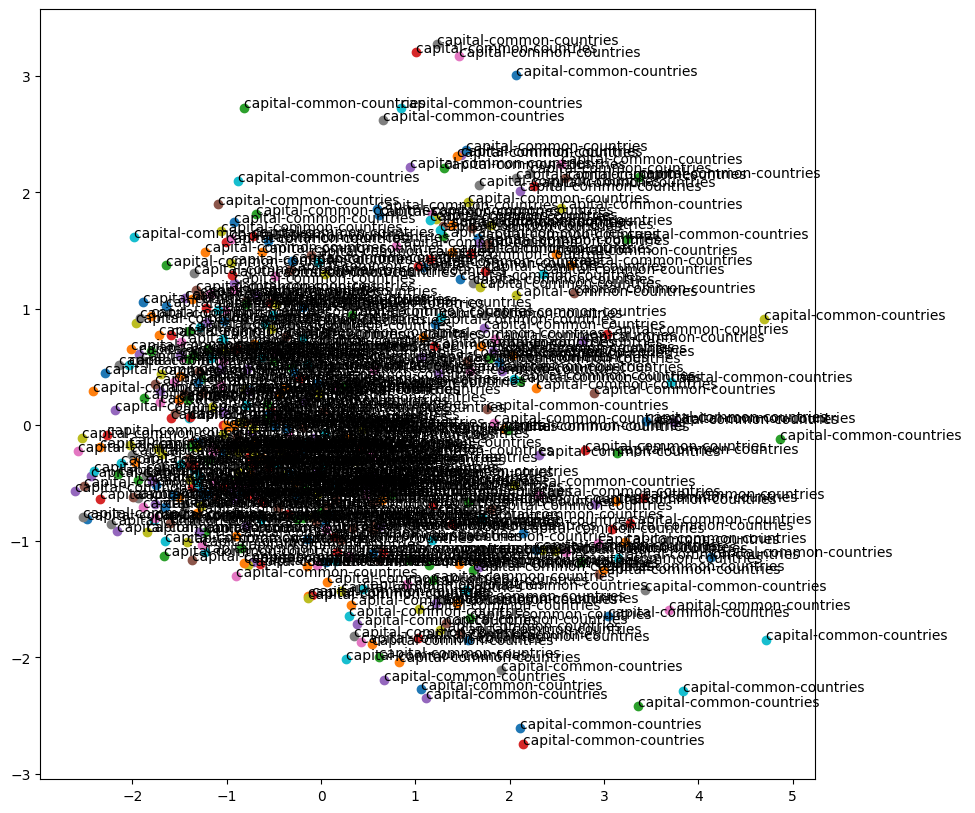


Group : currency

k = 1
Cos Simmiliairty Accuracy : 2.7714 
L2 Accuracy :  0.0000

k = 2
Cos Simmiliairty Accuracy : 9.8152 
L2 Accuracy :  0.0000

k = 5
Cos Simmiliairty Accuracy : 28.6374 
L2 Accuracy :  9.2379

k = 10
Cos Simmiliairty Accuracy : 35.9122 
L2 Accuracy :  24.1339

k = 20
Cos Simmiliairty Accuracy : 47.9215 
L2 Accuracy :  45.9584
0.26262710244044185


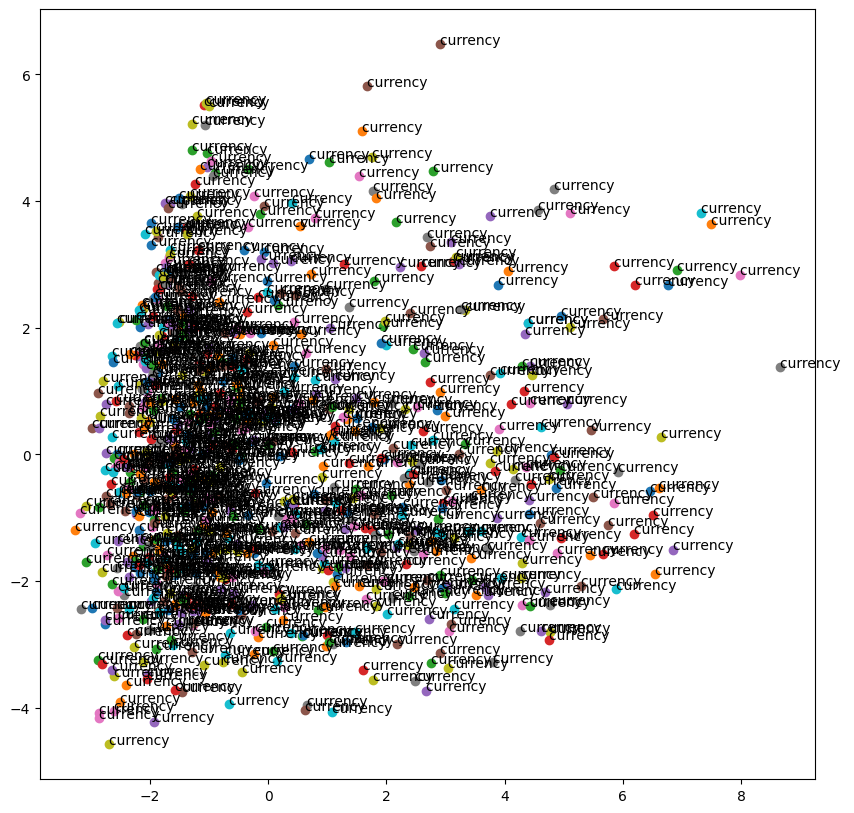


Group : city-in-state

k = 1
Cos Simmiliairty Accuracy : 12.7685 
L2 Accuracy :  3.0401

k = 2
Cos Simmiliairty Accuracy : 13.7819 
L2 Accuracy :  3.3239

k = 5
Cos Simmiliairty Accuracy : 26.7937 
L2 Accuracy :  6.0803

k = 10
Cos Simmiliairty Accuracy : 41.5890 
L2 Accuracy :  23.5103

k = 20
Cos Simmiliairty Accuracy : 56.3437 
L2 Accuracy :  44.2238
0.23007517912286918


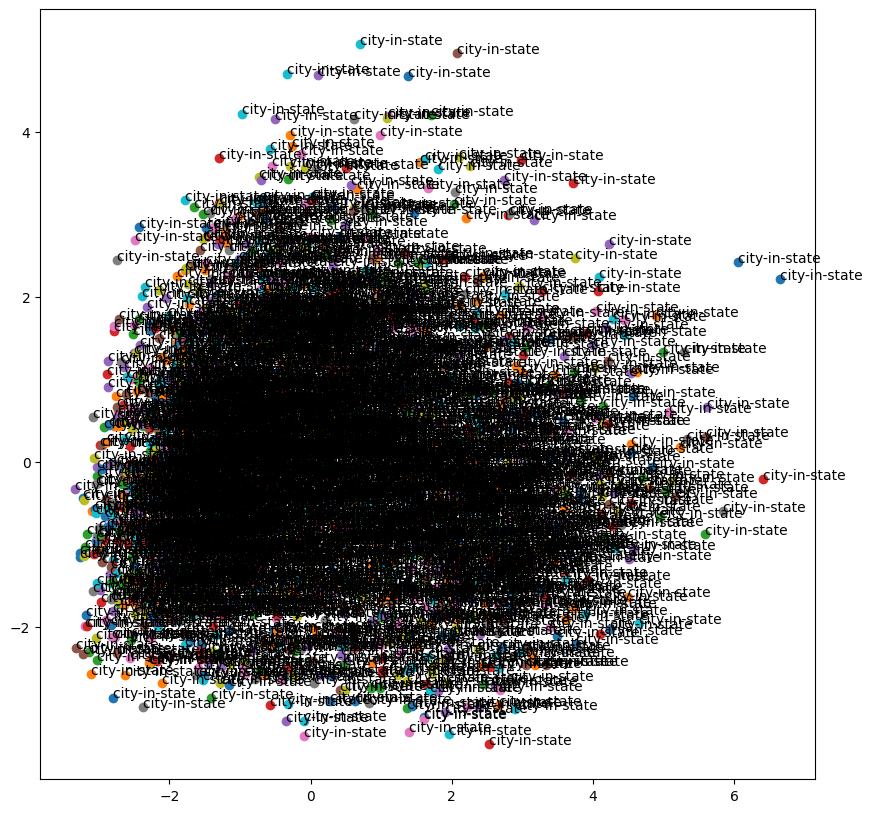

In [8]:
#groups = ('capital-common-countries')
groups = ('capital-common-countries', 'currency', 'city-in-state')

k_group= (1,2,5,10,20)
for group in groups:
    print(f'\nGroup : {group}')
    data = dataset[group]
    prediction(data,model,tokenizer, k_group, group)

## Accuracy for capital-common-countries
|k    |Accuracy Using Cosine Similarity (larger is closer)|Accuracy Using L2 Distance (smaller is closer)|  
|:--- |                  :---                             |                         :---                 |
| 1   |                     4.3478                        |                       12.0553                |
| 2   |                   12.6482                         |                       12.0553                |
| 5   |                  17.7866                          |                       25.6917                |
| 10  |                  37.9447                          |                      37.3518                 |
| 20  |                  56.3241                          |                       66.4032                |

## Accuracy for currency
|k    |Accuracy Using Cosine Similarity (larger is closer)|Accuracy Using L2 Distance (smaller is closer)|
|:--- |                  :---                             |                         :---                 |
| 1   |                     2.7714                        |                       0.0000                 |
| 2   |                    9.8152                         |                       0.0000                 |
| 5   |                  28.6374                          |                       9.2379                 |
| 10  |                  35.9122                          |                      24.1339                 |
| 20  |                  47.9215                          |                      45.9584                 |

## Accuracy for city-in-state
|k    |Accuracy Using Cosine Similarity (larger is closer)|Accuracy Using L2 Distance (smaller is closer)|
|:--- |                  :---                             |                         :---                 |
| 1   |                    12.7685                        |                       3.0401                 |
| 2   |                     13.7819                       |                       3.3239                 |
| 5   |                  26.7937                           |                       6.0803                 |
| 10  |                  41.5890                          |                      23.5103                 |
| 20  |                  56.3437                          |                      44.2238                 |

In [10]:

from scipy.spatial.distance import pdist,squareform
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [11]:
def embed(data, tokenizer,model):
    MAX_LEN = max_length(data)
    input_id, attention_mask  = encode(tokenizer, data)
    return embedding(model, input_id, attention_mask).detach().numpy()

Text(0.5, 1.0, 'visualizing sentence semantic similarity')

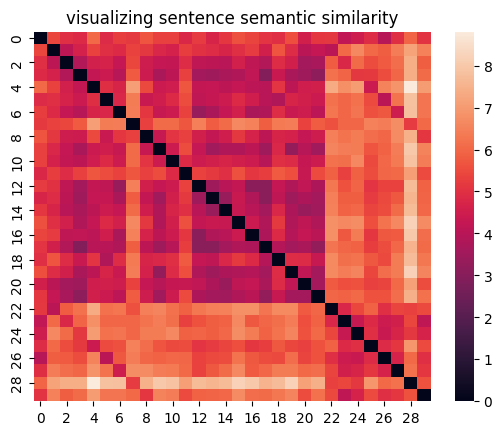

In [14]:
#'currency', 'city-in-state')
data = dataset['capital-common-countries']
sentence_features = embed(data[:30],tokenizer,model)
array_similarity = squareform(pdist(sentence_features, metric='euclidean'))
sns.heatmap(array_similarity)
plt.title('visualizing sentence semantic similarity')

Text(0.5, 1.0, 'visualizing sentence semantic similarity')

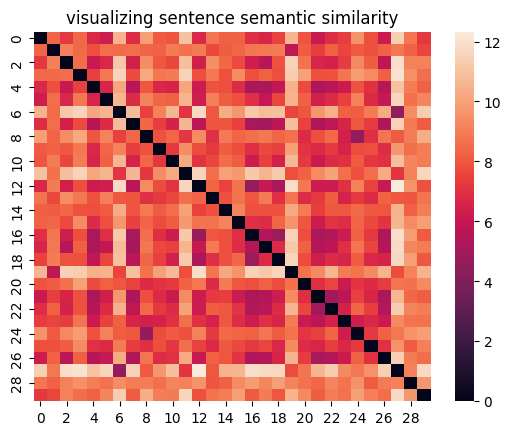

In [15]:
data = dataset['currency']
sentence_features = embed(data[:30],tokenizer,model)
array_similarity = squareform(pdist(sentence_features, metric='euclidean'))
sns.heatmap(array_similarity)
plt.title('visualizing sentence semantic similarity')

Text(0.5, 1.0, 'visualizing sentence semantic similarity')

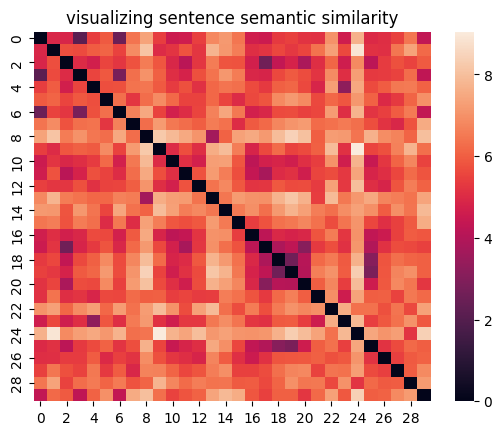

In [16]:
data = dataset['city-in-state']
sentence_features = embed(data[:30],tokenizer,model)
array_similarity = squareform(pdist(sentence_features, metric='euclidean'))
sns.heatmap(array_similarity)
plt.title('visualizing sentence semantic similarity')